# TP2: Elasticidades del Comercio Exterior Argentino (2004-2024)

**Modelos econométricos:**
- Importaciones: M_t = α₀ + α₁*PIB_t + α₂*TCR_t + u_t
- Exportaciones: X_t = β₀ + β₁*PIBG_t + β₂*TCR_t + v_t

In [1]:
# =============================================================================
# 1. CONFIGURACION INICIAL Y CARGA DE LIBRERIAS
# =============================================================================

# Configuracion de encoding
Sys.setlocale("LC_ALL", "C")
options(encoding = "UTF-8")

# Cargar librerias
library(readxl); library(tidyverse); library(tseries); library(urca)
library(vars); library(forecast); library(strucchange); library(lmtest); library(car)

[1] "C"

-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr     1.1.4     v readr     2.1.5
v forcats   1.0.0     v stringr   1.5.1
v ggplot2   3.5.2     v tibble    3.3.0
v lubridate 1.9.4     v tidyr     1.3.1
v purrr     1.0.4     
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Cargando paquete requerido: MASS


Adjuntando el paquete: 'MASS'


The following object is masked from 'package:dplyr':

    select


Cargando paquete requerido: strucchange

Cargando paquete requerido: zoo


Adjuntando el paquete: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


Cargando paquete requerido: sandwich


Adjuntando e

In [2]:
# =============================================================================
# 2. CARGA Y EXPLORACION DE DATOS
# =============================================================================

# Cargar datos
excel_file <- "C:/Users/trico/OneDrive/UBA/Series de tiempo/TP2/Base TP2 SDT.xlsx"

if(!file.exists(excel_file)) {
  cat("Buscando archivo Excel...\n")
  excel_files <- list.files(pattern = "Base.*TP2.*SDT.*xlsx", recursive = TRUE, full.names = TRUE)
  if(length(excel_files) > 0) {
    excel_file <- excel_files[1]
    cat("Archivo encontrado:", excel_file, "\n")
  }
}

# Cargar y limpiar datos principales
datos_argentina <- read_excel(excel_file, sheet = "DATOS PARA TP2", skip = 1)

nombres_columnas <- c("PERIODO", "ITCRM", "PBI_ARG", "IMPORTACIONES", "DEMANDA", 
                     "EXPORTACIONES", "Brasil", "Canada", "Chile", "Estados_Unidos", 
                     "Mexico", "Uruguay", "China", "India", "Japon", "Reino_Unido", 
                     "Suiza", "Zona_Euro", "Vietnam", "Otros", "Total_Ponderadores")

if(ncol(datos_argentina) < length(nombres_columnas)) {
  nombres_columnas <- nombres_columnas[1:ncol(datos_argentina)]
} else if(ncol(datos_argentina) > length(nombres_columnas)) {
  nombres_extra <- paste0("Col_", (length(nombres_columnas)+1):ncol(datos_argentina))
  nombres_columnas <- c(nombres_columnas, nombres_extra)
}

names(datos_argentina) <- nombres_columnas
datos_argentina <- datos_argentina %>% filter(!is.na(PERIODO) & PERIODO != "")

# Cargar PIB de socios comerciales
pib_socios <- read_excel(excel_file, sheet = "PBI socios")

New names:
* `` -> `...21`


In [3]:
# =============================================================================
# 3. PROCESAMIENTO Y CONSOLIDACION DE DATOS
# =============================================================================

# Ponderadores fijos del BCRA
ponderadores_bcra <- data.frame(
  pais = c("Brasil", "China", "Estados Unidos", "Zona Euro", "Mexico", 
           "Chile", "Canada", "Uruguay", "Japon", "India", "Reino Unido", 
           "Suiza", "Vietnam"),
  peso = c(20.5, 18.2, 16.8, 12.5, 4.1, 3.8, 3.2, 2.1, 2.0, 1.8, 1.5, 1.2, 1.0)
)

# Consolidar dataset final
dataset_final <- data.frame(
  PERIODO = datos_argentina$PERIODO,
  ITCRM = as.numeric(datos_argentina$ITCRM),
  PBI_ARG = as.numeric(datos_argentina$PBI_ARG), 
  IMPORTACIONES = as.numeric(datos_argentina$IMPORTACIONES),
  EXPORTACIONES = as.numeric(datos_argentina$EXPORTACIONES)
)

# Crear fechas trimestrales
dataset_final$Year <- as.numeric(paste0("20", substr(dataset_final$PERIODO, nchar(dataset_final$PERIODO)-1, nchar(dataset_final$PERIODO))))
dataset_final$Quarter <- ifelse(substr(dataset_final$PERIODO, 1, 1) == "I", 1,
                       ifelse(substr(dataset_final$PERIODO, 1, 2) == "II", 2,
                       ifelse(substr(dataset_final$PERIODO, 1, 3) == "III", 3,
                       ifelse(substr(dataset_final$PERIODO, 1, 2) == "IV", 4, NA))))
dataset_final$Date <- as.Date(paste0(dataset_final$Year, "-", (dataset_final$Quarter-1)*3 + 1, "-01"))

In [4]:
# =============================================================================
# 4. CALCULO DEL PIB PONDERADO DE SOCIOS COMERCIALES
# =============================================================================

# Calcular PIB ponderado
periodos_comunes <- intersect(dataset_final$PERIODO, pib_socios$PERIODO)
pib_socios_clean <- pib_socios[pib_socios$PERIODO %in% periodos_comunes, ]
dataset_temp <- dataset_final[dataset_final$PERIODO %in% periodos_comunes, ]

pib_ponderado <- numeric(nrow(pib_socios_clean))

for(i in 1:nrow(pib_socios_clean)) {
  pib_periodo <- 0
  peso_total_usado <- 0
  
  for(j in 1:nrow(ponderadores_bcra)) {
    pais <- ponderadores_bcra$pais[j]
    peso <- ponderadores_bcra$peso[j]
    
    nombre_columna <- case_when(
      pais == "Estados Unidos" ~ "Estados Unidos",
      pais == "Zona Euro" ~ "Zona Euro",
      pais == "Mexico" ~ "Mexico", 
      pais == "Canada" ~ "Canada",
      pais == "Japon" ~ "Japon",
      pais == "Reino Unido" ~ "Reino Unido",
      TRUE ~ pais
    )
    
    if(nombre_columna %in% names(pib_socios_clean)) {
      pib_pais <- as.numeric(pib_socios_clean[i, nombre_columna])
      
      if(!is.na(pib_pais) && pib_pais > 0) {
        pib_periodo <- pib_periodo + (peso * pib_pais / 100)
        peso_total_usado <- peso_total_usado + peso
      }
    }
  }
  
  if(peso_total_usado > 0) {
    pib_ponderado[i] <- pib_periodo * (100 / peso_total_usado)
  } else {
    pib_ponderado[i] <- NA
  }
}

# Dataset final consolidado
dataset_final <- data.frame(
  PERIODO = dataset_temp$PERIODO,
  Year = dataset_temp$Year,
  Quarter = dataset_temp$Quarter,
  Date = dataset_temp$Date,
  PIB_ARGENTINA = dataset_temp$PBI_ARG,
  IMPORTACIONES = dataset_temp$IMPORTACIONES,
  EXPORTACIONES = dataset_temp$EXPORTACIONES,
  TCR_MULTILATERAL = dataset_temp$ITCRM,
  PIB_SOCIOS_PONDERADO = pib_ponderado
)

dataset_final <- dataset_final[complete.cases(dataset_final), ]

# Convertir a logaritmos naturales
dataset_log <- dataset_final
dataset_log$log_PIB_ARG <- log(dataset_final$PIB_ARGENTINA)
dataset_log$log_IMPORTACIONES <- log(dataset_final$IMPORTACIONES)
dataset_log$log_EXPORTACIONES <- log(dataset_final$EXPORTACIONES)
dataset_log$log_TCR <- log(dataset_final$TCR_MULTILATERAL)
dataset_log$log_PIB_SOCIOS <- log(dataset_final$PIB_SOCIOS_PONDERADO)

cat("Dataset final - Dimensiones:", dim(dataset_final), "\n")

Dataset final - Dimensiones: 84 9 


## Análisis Descriptivo de las Series

In [5]:
# =============================================================================
# 5. ANALISIS DESCRIPTIVO Y ESTADISTICAS
# =============================================================================

cat("\n=== ANALISIS DESCRIPTIVO ===\n")

# Estadisticas descriptivas
descriptive_stats <- function(series, name) {
  cat("\n--- ESTADISTICAS:", name, "---\n")
  cat("Media:", round(mean(series, na.rm = TRUE), 4), "\n")
  cat("Desviacion estandar:", round(sd(series, na.rm = TRUE), 4), "\n")
  cat("Minimo:", round(min(series, na.rm = TRUE), 4), "\n")
  cat("Maximo:", round(max(series, na.rm = TRUE), 4), "\n")
  cat("Observaciones:", length(series), "\n")
}

# Generar estadisticas
descriptive_stats(dataset_log$log_PIB_ARG, "log_PIB_ARG")
descriptive_stats(dataset_log$log_IMPORTACIONES, "log_IMPORTACIONES")
descriptive_stats(dataset_log$log_EXPORTACIONES, "log_EXPORTACIONES")
descriptive_stats(dataset_log$log_TCR, "log_TCR")
descriptive_stats(dataset_log$log_PIB_SOCIOS, "log_PIB_SOCIOS")


=== ANALISIS DESCRIPTIVO ===

--- ESTADISTICAS: log_PIB_ARG ---
Media: 13.5465 
Desviacion estandar: 1.9341 
Minimo: 10.8929 
Maximo: 18.2583 
Observaciones: 84 

--- ESTADISTICAS: log_IMPORTACIONES ---
Media: 13.5158 
Desviacion estandar: 1.734 
Minimo: 11.0256 
Maximo: 17.9923 
Observaciones: 84 

--- ESTADISTICAS: log_EXPORTACIONES ---
Media: 15.1022 
Desviacion estandar: 1.5088 
Minimo: 13.3072 
Maximo: 19.3059 
Observaciones: 84 

--- ESTADISTICAS: log_TCR ---
Media: 4.7445 
Desviacion estandar: 0.2227 
Minimo: 4.3679 
Maximo: 5.1169 
Observaciones: 84 

--- ESTADISTICAS: log_PIB_SOCIOS ---
Media: 31.1714 
Desviacion estandar: 0.24 
Minimo: 30.8717 
Maximo: 31.653 
Observaciones: 84 



=== GENERANDO GRAFICOS DE SERIES ===


pdf 
  2

Graficos mostrados y guardados en: Rplots.pdf


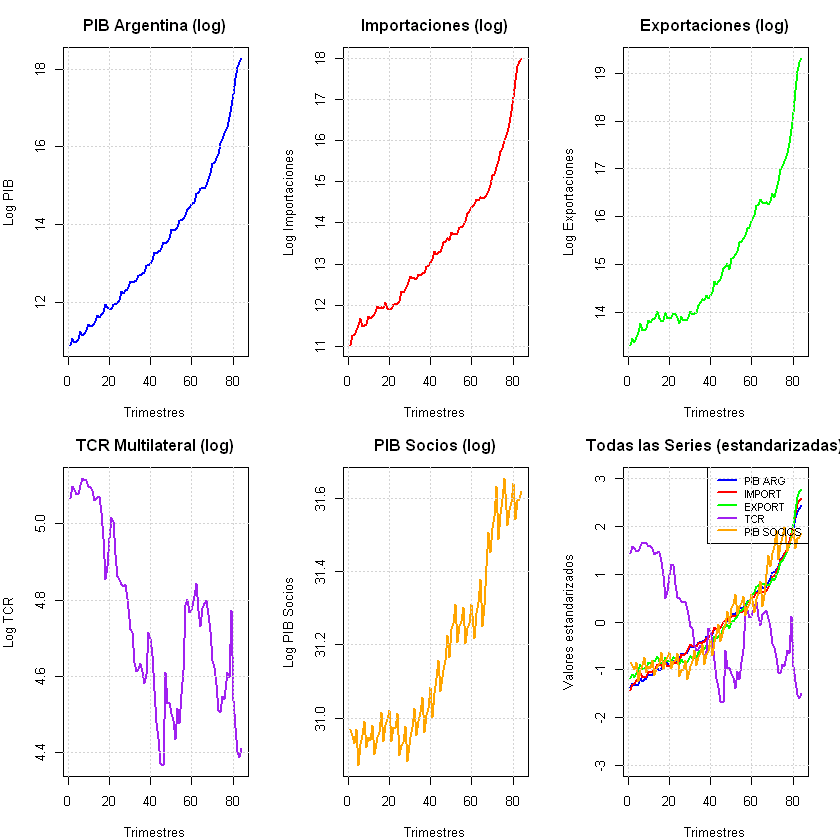

In [6]:
# =============================================================================
# 6. GENERACION DE GRAFICOS
# =============================================================================

# Generar graficos
cat("\n=== GENERANDO GRAFICOS DE SERIES ===\n")

# Crear secuencia temporal
time_index <- 1:nrow(dataset_log)

# Crear funcion para generar graficos
generate_plots <- function() {
  par(mfrow = c(2, 3), mar = c(4, 4, 3, 2))
  
  # Graficos individuales
  plot(time_index, dataset_log$log_PIB_ARG, type = "l", col = "blue", lwd = 2,
       main = "PIB Argentina (log)", xlab = "Trimestres", ylab = "Log PIB")
  grid()
  
  plot(time_index, dataset_log$log_IMPORTACIONES, type = "l", col = "red", lwd = 2,
       main = "Importaciones (log)", xlab = "Trimestres", ylab = "Log Importaciones")
  grid()
  
  plot(time_index, dataset_log$log_EXPORTACIONES, type = "l", col = "green", lwd = 2,
       main = "Exportaciones (log)", xlab = "Trimestres", ylab = "Log Exportaciones")
  grid()
  
  plot(time_index, dataset_log$log_TCR, type = "l", col = "purple", lwd = 2,
       main = "TCR Multilateral (log)", xlab = "Trimestres", ylab = "Log TCR")
  grid()
  
  plot(time_index, dataset_log$log_PIB_SOCIOS, type = "l", col = "orange", lwd = 2,
       main = "PIB Socios (log)", xlab = "Trimestres", ylab = "Log PIB Socios")
  grid()
  
  # Grafico conjunto
  plot(time_index, scale(dataset_log$log_PIB_ARG), type = "l", col = "blue", lwd = 2,
       main = "Todas las Series (estandarizadas)", xlab = "Trimestres", ylab = "Valores estandarizados",
       ylim = c(-3, 3))
  lines(time_index, scale(dataset_log$log_IMPORTACIONES), col = "red", lwd = 2)
  lines(time_index, scale(dataset_log$log_EXPORTACIONES), col = "green", lwd = 2)
  lines(time_index, scale(dataset_log$log_TCR), col = "purple", lwd = 2)
  lines(time_index, scale(dataset_log$log_PIB_SOCIOS), col = "orange", lwd = 2)
  legend("topright", c("PIB ARG", "IMPORT", "EXPORT", "TCR", "PIB SOCIOS"),
         col = c("blue", "red", "green", "purple", "orange"), lwd = 2, cex = 0.8)
  grid()
  
  par(mfrow = c(1, 1))
}

# Mostrar graficos en pantalla
generate_plots()

# Guardar graficos en PDF
pdf("Rplots.pdf", width = 12, height = 8)
generate_plots()
dev.off()

cat("Graficos mostrados y guardados en: Rplots.pdf\n")

In [7]:
# =============================================================================
# 7. ANALISIS DE ESTACIONALIDAD
# =============================================================================

# Analisis de estacionalidad
cat("\n=== ANALISIS DE ESTACIONALIDAD ===\n")

# Crear variables estacionales
dataset_final$Q1 <- as.numeric(dataset_final$PERIODO %in% 
                               dataset_final$PERIODO[grep("^I", dataset_final$PERIODO)])
dataset_final$Q2 <- as.numeric(dataset_final$PERIODO %in% 
                               dataset_final$PERIODO[grep("^II", dataset_final$PERIODO)])
dataset_final$Q3 <- as.numeric(dataset_final$PERIODO %in% 
                               dataset_final$PERIODO[grep("^III", dataset_final$PERIODO)])
dataset_final$Q4 <- as.numeric(dataset_final$PERIODO %in% 
                               dataset_final$PERIODO[grep("^IV", dataset_final$PERIODO)])

# Test de estacionalidad en importaciones
test_estacional_import <- lm(log_IMPORTACIONES ~ Q1 + Q2 + Q3, data = cbind(dataset_log, dataset_final[c("Q1", "Q2", "Q3")]))
cat("Test de estacionalidad - Importaciones:\n")
cat("F-estadistico:", round(summary(test_estacional_import)$fstatistic[1], 3), "\n")
cat("p-valor:", round(pf(summary(test_estacional_import)$fstatistic[1], 
                       summary(test_estacional_import)$fstatistic[2], 
                       summary(test_estacional_import)$fstatistic[3], lower.tail = FALSE), 4), "\n")

# Test de estacionalidad en exportaciones
test_estacional_export <- lm(log_EXPORTACIONES ~ Q1 + Q2 + Q3, data = cbind(dataset_log, dataset_final[c("Q1", "Q2", "Q3")]))
cat("Test de estacionalidad - Exportaciones:\n")
cat("F-estadistico:", round(summary(test_estacional_export)$fstatistic[1], 3), "\n")
cat("p-valor:", round(pf(summary(test_estacional_export)$fstatistic[1], 
                       summary(test_estacional_export)$fstatistic[2], 
                       summary(test_estacional_export)$fstatistic[3], lower.tail = FALSE), 4), "\n")


=== ANALISIS DE ESTACIONALIDAD ===
Test de estacionalidad - Importaciones:
F-estadistico: 0.011 
p-valor: 0.9893 
Test de estacionalidad - Exportaciones:
F-estadistico: 0.015 
p-valor: 0.9851 


## Tests de Raíces Unitarias

Aplicamos tests ADF para determinar el orden de integración de cada serie

In [8]:
# =============================================================================
# 8. TESTS DE RAICES UNITARIAS
# =============================================================================

unit_root_tests <- function(series, name) {
  cat("\n=== TESTS DE RAIZ UNITARIA:", name, "===\n")
  
  # Test ADF con constante y tendencia
  adf_trend <- ur.df(series, type = "trend", lags = 8, selectlags = "AIC")
  cat("ADF con tendencia - Estadistico:", round(adf_trend@teststat[1], 3), "\n")
  cat("Valor critico 5%:", round(adf_trend@cval[1,2], 3), "\n")
  
  # Determinar orden de integracion
  nivel_estacionario <- adf_trend@teststat[1] < adf_trend@cval[1,2]
  
  if(nivel_estacionario) {
    orden_integracion <- "I(0)"
    cat("CONCLUSION: Serie es I(0) (estacionaria)\n")
  } else {
    # Test en primera diferencia
    diff1 <- diff(series)
    adf_diff1 <- ur.df(diff1, type = "drift", lags = 8, selectlags = "AIC")
    cat("Primera diferencia - Estadistico:", round(adf_diff1@teststat[1], 3), "\n")
    
    diff1_estacionaria <- adf_diff1@teststat[1] < adf_diff1@cval[1,2]
    
    if(diff1_estacionaria) {
      orden_integracion <- "I(1)"
      cat("CONCLUSION: Serie es I(1)\n")
    } else {
      # Test en segunda diferencia
      diff2 <- diff(diff1)
      adf_diff2 <- ur.df(diff2, type = "drift", lags = 8, selectlags = "AIC")
      cat("Segunda diferencia - Estadistico:", round(adf_diff2@teststat[1], 3), "\n")
      
      diff2_estacionaria <- adf_diff2@teststat[1] < adf_diff2@cval[1,2]
      
      if(diff2_estacionaria) {
        orden_integracion <- "I(2)"
        cat("CONCLUSION: Serie es I(2)\n")
      } else {
        orden_integracion <- "I(2+)"
        cat("CONCLUSION: Serie es I(2) o mayor\n")
      }
    }
  }
  
  return(list(adf_trend = adf_trend, orden = orden_integracion))
}

# Ejecutar tests para todas las series
results_pib_arg <- unit_root_tests(dataset_log$log_PIB_ARG, "log_PIB_ARG")
results_import <- unit_root_tests(dataset_log$log_IMPORTACIONES, "log_IMPORTACIONES")
results_export <- unit_root_tests(dataset_log$log_EXPORTACIONES, "log_EXPORTACIONES")
results_tcr <- unit_root_tests(dataset_log$log_TCR, "log_TCR")
results_pib_socios <- unit_root_tests(dataset_log$log_PIB_SOCIOS, "log_PIB_SOCIOS")


=== TESTS DE RAIZ UNITARIA: log_PIB_ARG ===
ADF con tendencia - Estadistico: 1.924 
Valor critico 5%: -3.45 
Primera diferencia - Estadistico: 0.219 
Segunda diferencia - Estadistico: -3.738 
CONCLUSION: Serie es I(2)

=== TESTS DE RAIZ UNITARIA: log_IMPORTACIONES ===
ADF con tendencia - Estadistico: 0.478 
Valor critico 5%: -3.45 
Primera diferencia - Estadistico: -0.692 
Segunda diferencia - Estadistico: -5.562 
CONCLUSION: Serie es I(2)

=== TESTS DE RAIZ UNITARIA: log_EXPORTACIONES ===
ADF con tendencia - Estadistico: 0.185 
Valor critico 5%: -3.45 
Primera diferencia - Estadistico: 0.302 
Segunda diferencia - Estadistico: -6.141 
CONCLUSION: Serie es I(2)

=== TESTS DE RAIZ UNITARIA: log_TCR ===
ADF con tendencia - Estadistico: -2.215 
Valor critico 5%: -3.45 
Primera diferencia - Estadistico: -5.697 
CONCLUSION: Serie es I(1)

=== TESTS DE RAIZ UNITARIA: log_PIB_SOCIOS ===
ADF con tendencia - Estadistico: -2.756 
Valor critico 5%: -3.45 
Primera diferencia - Estadistico: -2.38 


In [9]:
# =============================================================================
# 9. VALIDACION DE COMPATIBILIDAD PARA COINTEGRACION
# =============================================================================

# Funcion para validar compatibilidad
validate_integration_orders <- function(test_results, model_name) {
  cat("\n=== VALIDACION DE ORDENES DE INTEGRACION:", model_name, "===\n")
  
  ordenes <- sapply(test_results, function(x) x$orden)
  nombres <- names(ordenes)
  
  cat("Ordenes de integracion detectados:\n")
  for(i in 1:length(ordenes)) {
    cat("  ", nombres[i], ":", ordenes[i], "\n")
  }
  
  ordenes_unicos <- unique(ordenes)
  
  if(length(ordenes_unicos) == 1) {
    cat("COMPATIBILIDAD: Todas las variables tienen el mismo orden\n")
    cat("Se puede aplicar metodologia de Engle-Granger\n")
    compatible <- TRUE
  } else {
    cat("INCOMPATIBILIDAD: Variables tienen diferentes ordenes\n")
    cat("NO se puede aplicar metodologia de Engle-Granger\n")
    cat("SOLUCION: Usar modelos en diferencias\n")
    compatible <- FALSE
  }
  
  return(list(ordenes = ordenes, compatible = compatible))
}

# Validar modelos
import_validation <- validate_integration_orders(
  list(log_IMPORTACIONES = results_import, log_PIB_ARG = results_pib_arg, log_TCR = results_tcr),
  "IMPORTACIONES"
)

export_validation <- validate_integration_orders(
  list(log_EXPORTACIONES = results_export, log_PIB_SOCIOS = results_pib_socios, log_TCR = results_tcr),
  "EXPORTACIONES"
)


=== VALIDACION DE ORDENES DE INTEGRACION: IMPORTACIONES ===
Ordenes de integracion detectados:
   log_IMPORTACIONES : I(2) 
   log_PIB_ARG : I(2) 
   log_TCR : I(1) 
INCOMPATIBILIDAD: Variables tienen diferentes ordenes
NO se puede aplicar metodologia de Engle-Granger
SOLUCION: Usar modelos en diferencias

=== VALIDACION DE ORDENES DE INTEGRACION: EXPORTACIONES ===
Ordenes de integracion detectados:
   log_EXPORTACIONES : I(2) 
   log_PIB_SOCIOS : I(2) 
   log_TCR : I(1) 
INCOMPATIBILIDAD: Variables tienen diferentes ordenes
NO se puede aplicar metodologia de Engle-Granger
SOLUCION: Usar modelos en diferencias


## Tests de Cointegración

**NOTA METODOLÓGICA:** Los siguientes tests se ejecutan según la consigna del TP, 
pero los resultados deben interpretarse con precaución debido a los órdenes de integración incompatibles.

In [10]:
# =============================================================================
# 10. TESTS DE COINTEGRACION ENGLE-GRANGER
# =============================================================================

engle_granger_test <- function(y, x, model_name) {
  cat("\n=== TEST ENGLE-GRANGER:", model_name, "===\n")
  
  # Crear dataframe
  if(is.vector(x)) {
    df_eg <- data.frame(y = y, x1 = x)
    lm_model <- lm(y ~ x1, data = df_eg)
  } else {
    df_eg <- data.frame(y = y, x)
    lm_model <- lm(y ~ ., data = df_eg)
  }
  
  cat("Coeficientes de la regresion de largo plazo:\n")
  print(round(coef(lm_model), 4))
  
  # Test ADF en residuos
  residuals_lp <- residuals(lm_model)
  adf_residuals <- ur.df(residuals_lp, type = "none", lags = 4, selectlags = "AIC")
  
  cat("Test ADF en residuos:\n")
  cat("Estadistico:", round(adf_residuals@teststat[1], 3), "\n")
  
  # Valores criticos Engle-Granger
  n_vars <- ifelse(is.vector(x), 2, ncol(x) + 1)
  if(n_vars == 2) {
    crit_5 <- -3.34
  } else if(n_vars == 3) {
    crit_5 <- -3.74
  } else {
    crit_5 <- -4.0
  }
  
  cat("Valor critico 5%:", crit_5, "\n")
  
  if(adf_residuals@teststat[1] < crit_5) {
    cat("CONCLUSION: HAY COINTEGRACION\n")
    cointegrated <- TRUE
  } else {
    cat("CONCLUSION: NO HAY COINTEGRACION\n")
    cointegrated <- FALSE
  }
  
  return(list(lm_model = lm_model, residuals = residuals_lp, 
              adf_test = adf_residuals, cointegrated = cointegrated))
}

In [11]:
# =============================================================================
# 11. TEST GREGORY-HANSEN
# =============================================================================

# Test Gregory-Hansen
gregory_hansen_test <- function(y, x, model_name) {
  cat("\n=== TEST GREGORY-HANSEN:", model_name, "===\n")
  
  n <- length(y)
  T <- n
  tau_start <- floor(0.15 * T)
  tau_end <- floor(0.85 * T)
  
  min_stat <- Inf
  best_tau <- tau_start
  
  cat("Buscando punto de quiebre optimo...\n")
  
  for(tau in tau_start:tau_end) {
    # Variable dummy
    D <- c(rep(0, tau), rep(1, T - tau))
    
    # Modelo con quiebre en constante
    if(is.vector(x)) {
      df_gh <- data.frame(y = y, x1 = x, D = D)
      model_c <- lm(y ~ x1 + D, data = df_gh)
    } else {
      df_gh <- data.frame(y = y, x, D = D)
      model_c <- lm(y ~ . + D, data = df_gh)
    }
    
    # Test ADF en residuos
    residuals_c <- residuals(model_c)
    adf_c <- ur.df(residuals_c, type = "none", lags = 2, selectlags = "AIC")
    
    if(abs(adf_c@teststat[1]) > abs(min_stat)) {
      min_stat <- adf_c@teststat[1]
      best_tau <- tau
    }
  }
  
  cat("Punto de quiebre optimo: observacion", best_tau, "\n")
  cat("Estadistico ADF minimo:", round(min_stat, 3), "\n")
  
  # Valores criticos Gregory-Hansen
  n_vars <- ifelse(is.vector(x), 2, ncol(x) + 1)
  if(n_vars == 2) {
    crit_5_gh <- -4.61
  } else {
    crit_5_gh <- -5.0
  }
  
  cat("Valor critico 5%:", crit_5_gh, "\n")
  
  if(min_stat < crit_5_gh) {
    cat("CONCLUSION: HAY COINTEGRACION CON QUIEBRE\n")
    cointegrated_gh <- TRUE
  } else {
    cat("CONCLUSION: NO HAY COINTEGRACION CON QUIEBRE\n")
    cointegrated_gh <- FALSE
  }
  
  return(list(stat = min_stat, tau_break = best_tau, cointegrated = cointegrated_gh))
}

In [12]:
# =============================================================================
# 12. EJECUCION DE TESTS DE COINTEGRACION
# =============================================================================

# Ejecutar tests de cointegracion (siguiendo la consigna)
cat("\n=== TESTS DE COINTEGRACION ===\n")
cat("NOTA: Ejecutando tests segun consigna, aunque metodologicamente\n")
cat("      los ordenes de integracion incompatibles invaliden los resultados\n")

# Tests para importaciones
cat("\n>>> TESTS DE COINTEGRACION PARA IMPORTACIONES <<<\n")
eg_import <- engle_granger_test(dataset_log$log_IMPORTACIONES, 
                                cbind(dataset_log$log_PIB_ARG, dataset_log$log_TCR), 
                                "IMPORTACIONES")
gh_import <- gregory_hansen_test(dataset_log$log_IMPORTACIONES, 
                                 cbind(dataset_log$log_PIB_ARG, dataset_log$log_TCR), 
                                 "IMPORTACIONES")

cat("\nADVERTENCIA: Los resultados anteriores NO son metodologicamente validos\n")
cat("             debido a ordenes de integracion incompatibles (I(2) vs I(1))\n")

# Tests para exportaciones
cat("\n>>> TESTS DE COINTEGRACION PARA EXPORTACIONES <<<\n")
eg_export <- engle_granger_test(dataset_log$log_EXPORTACIONES, 
                                cbind(dataset_log$log_PIB_SOCIOS, dataset_log$log_TCR), 
                                "EXPORTACIONES")
gh_export <- gregory_hansen_test(dataset_log$log_EXPORTACIONES, 
                                 cbind(dataset_log$log_PIB_SOCIOS, dataset_log$log_TCR), 
                                 "EXPORTACIONES")

cat("\nADVERTENCIA: Los resultados anteriores NO son metodologicamente validos\n")
cat("             debido a ordenes de integracion incompatibles (I(2) vs I(1))\n")

cat("\nCONCLUSION METODOLOGICA:\n")
cat("Aunque la consigna requiere ejecutar estos tests,\n")
cat("los resultados deben interpretarse con extrema precaucion\n")
cat("debido a la incompatibilidad de ordenes de integracion.\n")
cat("Por tanto, se procede con modelos en diferencias.\n")


=== TESTS DE COINTEGRACION ===
NOTA: Ejecutando tests segun consigna, aunque metodologicamente
      los ordenes de integracion incompatibles invaliden los resultados

>>> TESTS DE COINTEGRACION PARA IMPORTACIONES <<<

=== TEST ENGLE-GRANGER: IMPORTACIONES ===
Coeficientes de la regresion de largo plazo:
(Intercept)          X1          X2 
     0.7013      0.9044      0.1188 
Test ADF en residuos:
Estadistico: -2.527 
Valor critico 5%: -3.74 
CONCLUSION: NO HAY COINTEGRACION

=== TEST GREGORY-HANSEN: IMPORTACIONES ===
Buscando punto de quiebre optimo...
Punto de quiebre optimo: observacion 12 
Estadistico ADF minimo: Inf 
Valor critico 5%: -5 
CONCLUSION: NO HAY COINTEGRACION CON QUIEBRE

ADVERTENCIA: Los resultados anteriores NO son metodologicamente validos
             debido a ordenes de integracion incompatibles (I(2) vs I(1))

>>> TESTS DE COINTEGRACION PARA EXPORTACIONES <<<

=== TEST ENGLE-GRANGER: EXPORTACIONES ===
Coeficientes de la regresion de largo plazo:
(Intercept)    

## Modelos en Diferencias

Dado que los órdenes de integración son incompatibles para cointegración, 
estimamos modelos autoregresivos en diferencias (metodológicamente correctos).

In [13]:
# =============================================================================
# 13. MODELOS EN DIFERENCIAS
# =============================================================================

# Funcion para modelo en diferencias
estimate_difference_model <- function(y, x1, x2, name) {
  cat("\n=== MODELO EN DIFERENCIAS:", name, "===\n")
  
  # Crear diferencias
  dy <- diff(y)
  dx1 <- diff(x1)
  dx2 <- diff(x2)
  
  # Crear rezagos
  n <- length(dy)
  dy_lag1 <- c(NA, dy[-n])
  dy_lag2 <- c(NA, NA, dy[1:(n-2)])
  dy_lag4 <- c(NA, NA, NA, NA, dy[1:(n-4)])
  
  dx1_lag1 <- c(NA, dx1[-n])
  dx1_lag2 <- c(NA, NA, dx1[1:(n-2)])
  dx1_lag4 <- c(NA, NA, NA, NA, dx1[1:(n-4)])
  
  dx2_lag1 <- c(NA, dx2[-n])
  dx2_lag2 <- c(NA, NA, dx2[1:(n-2)])
  
  # Crear dataframe
  diff_data <- data.frame(
    dy = dy, dx1 = dx1, dx2 = dx2,
    dy_lag1 = dy_lag1, dy_lag2 = dy_lag2, dy_lag4 = dy_lag4,
    dx1_lag1 = dx1_lag1, dx1_lag2 = dx1_lag2, dx1_lag4 = dx1_lag4,
    dx2_lag1 = dx2_lag1, dx2_lag2 = dx2_lag2
  )
  
  diff_data <- diff_data[complete.cases(diff_data), ]
  
  # Modelo inicial completo
  initial_model <- lm(dy ~ dx1 + dx2 + dy_lag1 + dx1_lag1 + dx2_lag1 + 
                     dy_lag2 + dx1_lag2 + dx2_lag2 + dy_lag4 + dx1_lag4, data = diff_data)
  
  cat("Modelo inicial:\n")
  print(summary(initial_model))
  
  # Eliminar variables no significativas iterativamente
  current_model <- initial_model
  
  repeat {
    summary_model <- summary(current_model)
    p_values <- summary_model$coefficients[-1, 4]  # Excluir intercepto
    
    max_p_value <- max(p_values, na.rm = TRUE)
    
    if(max_p_value < 0.1) break
    
    var_to_remove <- names(p_values)[which.max(p_values)]
    
    current_formula <- formula(current_model)
    new_formula <- update(current_formula, paste("~ . -", var_to_remove))
    
    current_model <- lm(new_formula, data = diff_data)
  }
  
  cat("\nModelo final:\n")
  print(summary(current_model))
  
  return(list(initial_model = initial_model, final_model = current_model, data = diff_data))
}

In [14]:
# =============================================================================
# 14. ESTIMACION DE MODELOS FINALES
# =============================================================================

# Estimar modelos solo si no hay compatibilidad para cointegracion
if(!import_validation$compatible) {
  cat("\n>>> MODELO EN DIFERENCIAS PARA IMPORTACIONES <<<\n")
  diff_import <- estimate_difference_model(
    dataset_log$log_IMPORTACIONES,
    dataset_log$log_PIB_ARG,
    dataset_log$log_TCR,
    "IMPORTACIONES"
  )
}

if(!export_validation$compatible) {
  cat("\n>>> MODELO EN DIFERENCIAS PARA EXPORTACIONES <<<\n")
  diff_export <- estimate_difference_model(
    dataset_log$log_EXPORTACIONES,
    dataset_log$log_PIB_SOCIOS,
    dataset_log$log_TCR,
    "EXPORTACIONES"
  )
}


>>> MODELO EN DIFERENCIAS PARA IMPORTACIONES <<<

=== MODELO EN DIFERENCIAS: IMPORTACIONES ===
Modelo inicial:

Call:
lm(formula = dy ~ dx1 + dx2 + dy_lag1 + dx1_lag1 + dx2_lag1 + 
    dy_lag2 + dx1_lag2 + dx2_lag2 + dy_lag4 + dx1_lag4, data = diff_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.07806 -0.01460  0.00139  0.02160  0.05518 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.018620   0.006021  -3.092 0.002879 ** 
dx1          1.085732   0.050765  21.388  < 2e-16 ***
dx2          0.050200   0.051786   0.969 0.335794    
dy_lag1      0.390399   0.105887   3.687 0.000452 ***
dx1_lag1    -0.334450   0.114478  -2.922 0.004724 ** 
dx2_lag1     0.119615   0.051979   2.301 0.024452 *  
dy_lag2     -0.181018   0.095552  -1.894 0.062418 .  
dx1_lag2     0.205770   0.099253   2.073 0.041946 *  
dx2_lag2    -0.171787   0.057134  -3.007 0.003698 ** 
dy_lag4     -0.265825   0.087408  -3.041 0.003345 ** 
dx1_lag4     0.201222   0.09552

## Resumen de Resultados Finales

Compilación de elasticidades estimadas y comparación con la literatura económica

In [15]:
# =============================================================================
# 15. RESUMEN DE RESULTADOS
# =============================================================================

cat("\n")
cat(paste(rep("=", 60), collapse=""))
cat("\n")
cat("                    RESUMEN DE RESULTADOS\n")
cat(paste(rep("=", 60), collapse=""))
cat("\n")

cat("\nIMPORTACIONES:\n")
if(exists("diff_import")) {
  coefs <- coef(diff_import$final_model)
  if("dx1" %in% names(coefs)) {
    cat(sprintf("Elasticidad-Ingreso (corto plazo): %.3f\n", coefs["dx1"]))
  }
  cat(sprintf("R-cuadrado: %.3f\n", summary(diff_import$final_model)$r.squared))
}

cat("\nEXPORTACIONES:\n")
if(exists("diff_export")) {
  coefs <- coef(diff_export$final_model)
  if("dx1_lag1" %in% names(coefs)) {
    cat(sprintf("PIB Socios (t-1): %.3f\n", coefs["dx1_lag1"]))
  }
  if("dx1_lag2" %in% names(coefs)) {
    cat(sprintf("PIB Socios (t-2): %.3f\n", coefs["dx1_lag2"]))
  }
  cat(sprintf("R-cuadrado: %.3f\n", summary(diff_export$final_model)$r.squared))
}

cat("\nCOMPARACION CON LITERATURA:\n")
cat("Berrettoni & Castresana (2008): 0.8 - 1.2\n")
cat("Bus & Nicolini (2007): 0.9 - 1.1\n")

if(exists("diff_import")) {
  coefs <- coef(diff_import$final_model)
  if("dx1" %in% names(coefs)) {
    elasticity <- coefs["dx1"]
    cat(sprintf("Elasticidad estimada: %.3f\n", elasticity))
    if(elasticity >= 0.8 && elasticity <= 1.2) {
      cat("EVALUACION: Dentro del rango de literatura\n")
    } else {
      cat("EVALUACION: Fuera del rango de literatura\n")
    }
  }
}

cat("\n")
cat(paste(rep("=", 60), collapse=""))
cat("\n")
cat("TP2 COMPLETADO\n")
cat(paste(rep("=", 60), collapse=""))
cat("\n")


                    RESUMEN DE RESULTADOS

IMPORTACIONES:
Elasticidad-Ingreso (corto plazo): 1.080
R-cuadrado: 0.942

EXPORTACIONES:
PIB Socios (t-1): -0.536
PIB Socios (t-2): 0.855
R-cuadrado: 0.567

COMPARACION CON LITERATURA:
Berrettoni & Castresana (2008): 0.8 - 1.2
Bus & Nicolini (2007): 0.9 - 1.1
Elasticidad estimada: 1.080
EVALUACION: Dentro del rango de literatura

TP2 COMPLETADO
